In [1]:
using CSV
using DataFrames
using PyPlot
using Statistics
using Printf

include("src/timeseries.jl")
include("src/bellman.jl")
include("src/searchUntilBellman.jl")
rc("font", family="sans-serif", size=16)

don't forget to 'set JULIA_NUM_THREADS=4'
you currently have 1 threads
or dedicate a single core at real-time priority for profiling


InterruptException: InterruptException:

# Currently defective (half through change from L2 to MSE)

In [2]:
overview_df = CSV.read("experiments_timed\\overview_timed.csv")
bellman_df = CSV.read("experiments2\\bellman_notable.csv")

function getAveragedExperiment(name, consideredLength)
    df = CSV.read("experiments_timed\\$(name).csv")
    generational = by(df, :generation) do df
        best_valid_L2 = mean(map(mse -> sqrt(mse*consideredLength), df.best_valid_mse))
    end
    population_size = filter(x -> x.name == name, overview_df)[:pop_size][1]
    generational.bornIndividuals = map(x -> (x+1) * population_size, generational.generation)
    return generational
end

function getExperimentsAndLabels(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:consideredLength] == consideredLength && row[:remaining_points] == remainingPoints, overview_df)
    results = [("name", "label") for i in 1:size(relevantEntries, 1)]
    for i in 1:size(relevantEntries, 1)
        label = "unclassified"
        if relevantEntries[:loop][i]
            if occursin("no special Individuals", relevantEntries[:description][i])
                label = "PLA-GA-L"
            else
                label = "PLA-GA"
            end
        else
            if occursin("no special Individuals", relevantEntries[:description][i])
                label = "PLA-GA-B"
            else
                label = "PLA-GA-S"
            end
        end
        results[i] = (relevantEntries[:name][i], label)
    end
    results_sorted = []
    #append!(results_sorted, filter(res -> res[2] == "PLA-GA-B", results))
    #append!(results_sorted, filter(res -> res[2] == "PLA-GA-S", results))
    #append!(results_sorted, filter(res -> res[2] == "PLA-GA-L", results))
    append!(results_sorted, filter(res -> res[2] == "PLA-GA", results))
    return results_sorted
end

function getBellman(dataset, consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:length] == consideredLength && row[:remaining_points] == remainingPoints, bellman_df)
    loops = Meta.parse(relevantEntries[:mses_10loops][1]) |> eval
    return relevantEntries[:mse][1], loops[10]
end

function getBellmanTime(consideredLength, remainingPoints)
    relevantEntries = filter(row -> row[:length] == consideredLength && row[:remaining_points] == remainingPoints, bellman_df)
    return mean(relevantEntries[:time])
end

function bellmanWCT_table()
    grouped = by(bellman_df, [:length, :remaining_points], sort=true, :time => mean, :time => minimum, :time => maximum)
    for i in 1:size(grouped, 1)
        print("\$", floor(Int, grouped[:length][i]/1000), "K\$ & \$")
        @printf "%0.2f" grouped[:time_mean][i]
        print("\$ & \$")
        @printf "%0.2f" grouped[:time_maximum][i] - grouped[:time_minimum][i]
        println("\$ \\\\")
    end
end

function plotProblem(dataset, consideredLength, remainingPoints)
    experiments_and_labels = getExperimentsAndLabels(dataset, consideredLength, remainingPoints)
    for pair in experiments_and_labels
        experiment = getAveragedExperiment(pair[1], consideredLength)
        plot(experiment[:generation], experiment[:x1], label=pair[2])
    end
    bellman_result, bellman_looped_result = getBellman(dataset, consideredLength, remainingPoints)
    plot([0, 500], [bellman_result, bellman_result], color="gray", linestyle="dashed", label="Bellman")
    #plot([0, 200000], [bellman_looped_result, bellman_looped_result], color="gray", linestyle="dotted", label="Bellman looped")
    title("$dataset[1:$consideredLength], down to $remainingPoints points")
    ylabel("avg. best L2-norm")
    xlabel("generation")
    #yscale("log")
    legend()
    xlim((0, 500))
    grid()
end

function plotScalingCompression(dataset, predicate=row->true)
    relevantEntries = filter(row -> row[:dataset] == dataset, overview_df)
    relevantEntries = filter(predicate, relevantEntries)
    problems = unique(collect(zip(relevantEntries[:consideredLength], relevantEntries[:remaining_points])))
    sort!(problems)
    n = length(problems)
    fig = figure("Overview of $dataset", figsize=(5,n*5))
    axs = []
    for i in 1:n
        ax = fig.add_subplot(n, 1,i)
        push!(axs, ax)
        plt.subplot(ax)
        plotProblem(dataset, problems[i][1], problems[i][2])
    end
    return fig, axs
end

function firstQuarter(array)
    return quantile(array, 0.25)
end

function thirdQuarter(array)
    return quantile(array, 0.75)
end

function boxplotTimeUntilBellman(dataset)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:loop] && occursin("contains special", row[:description]), overview_df)
    sort!(relevantEntries, [:consideredLength])
    bellmanTimes = []
    consideredLengths = []
    absoluteTimes = []
    relativeTimes = []
    labels = []
    for i in 1:size(relevantEntries, 1)
        consideredLength = relevantEntries[:consideredLength][i]
        remainingPoints = relevantEntries[:remaining_points][i]
        bellman_result, bellman_looped_result = getBellman(dataset, consideredLength, remainingPoints)
        df = CSV.read("experiments_timed/"*relevantEntries[:name][i]*".csv")
        numberRuns = length(unique(df[:run_id]))
        df_successful = filter(row -> row[:best_valid_mse] <= bellman_result, df)
        finish_df = by(df_successful, :run_id) do df
            time = minimum(df[:total_time])
        end
        numberSuccessful = size(finish_df, 1)
        bellmanTime = getBellmanTime(consideredLength, remainingPoints)
        push!(bellmanTimes, bellmanTime)
        push!(consideredLengths, consideredLength/1000)
        push!(absoluteTimes, finish_df.x1)
        push!(relativeTimes, bellmanTime ./ finish_df.x1)
        push!(labels, "$(floor(Int,consideredLength/1000))" * (numberSuccessful == 50 ? "" : "\n$numberSuccessful/$numberRuns"))
    end
    for i in 1:length(consideredLengths)
       println(consideredLengths[i], " ", mean(absoluteTimes[i])) 
    end
    fig = figure("Overview of $dataset", figsize=(2*8,5));
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    plt.subplot(ax1)
    plot(consideredLengths, bellmanTimes, label="Bellman", linewidth=2, marker="o")
    plot(consideredLengths, median.(absoluteTimes), label="GA-SL", linewidth=2, marker="o")
    fill_between(consideredLengths, firstQuarter.(absoluteTimes), thirdQuarter.(absoluteTimes), alpha=0.3, color="orange")
    xlabel("n in thousands")
    ylabel("WCT in seconds")
    legend(loc="upper left")
    plt.subplot(ax2)
    bp = boxplot(relativeTimes, labels=labels, whis=Inf, widths=0.8)
    for element in ["boxes", "whiskers", "fliers", "means", "medians", "caps"]
        plt.setp(bp[element], linewidth=2)
    end
    plt.setp(bp["means"], linestyle="solid")
    xlabel("n in thousands")
    ylabel("WCT speed-up factor")
    ylim(0)
    return ax1, ax2
end

function plotL2ofEstablished(consideredLength, remainingPoints)
    dataset_names = ["subject103_5", "subject103_6", "Ham", "Rock"]
    datasets = map(name -> datasetbyname(name)[1:consideredLength], dataset_names)
    bellmanL2 = map(name -> getBellman(name, consideredLength, remainingPoints)[1], dataset_names)
    dataset_labels = ["Subject5", "Subject6", "Ham", "Rock"]
    algos = [ramer_douglas_peucker, visvalingam_squarederror, swing_filter_number]
    algo_names = ["RDP", "Visvalingam", "Swing Filter"]
    colors = ["blue", "orange", "red"]
    for a in 1:length(algos)
        algo = algos[a]
        @show algo
        relativeErrors = []
        relativeOpysErrors = []
        for i in 1:length(datasets)
            ts = datasets[i]
            @show dataset_names[i]
            compressed, geno = algo(ts, remainingPoints)
            push!(relativeErrors, sqrt(mse(compressed, ts) * consideredLength)/bellmanL2[i])
            ind = Individual(geno, ts)
            push!(relativeOpysErrors, sqrt(ind.mse * consideredLength)/bellmanL2[i])
        end
        scatter(1:length(datasets), relativeErrors, c=colors[a], label=algo_names[a])
        scatter(1:length(datasets), relativeOpysErrors, c=colors[a], marker="x")
    end
    xticks(1:length(datasets), dataset_labels)
    ylabel("relative L2-norm")
    ylim(1,4)
    legend()
end

plotL2ofEstablished (generic function with 1 method)

In [13]:
firstQuarter(array) = quantile(array, 0.25)
thirdQuarter(array) = quantile(array, 0.75)

function plotTimeUntilBellman(dataset)
    relevantEntries = filter(row -> row[:dataset] == dataset && row[:loop] && occursin("contains special", row[:description]), overview_df)
    sort!(relevantEntries, [:consideredLength])
    bellmanTimes = []
    consideredLengths = []
    absoluteTimes = []
    for i in 1:size(relevantEntries, 1)
        consideredLength = relevantEntries[:consideredLength][i]
        remainingPoints = relevantEntries[:remaining_points][i]
        bellman_mse, bellman_looped_mse = getBellman(dataset, consideredLength, remainingPoints)
        df = CSV.read("experiments_timed/"*relevantEntries[:name][i]*".csv")
        numberRuns = length(unique(df[:run_id]))
        df_successful = filter(row -> row[:best_valid_mse] <= bellman_mse, df)
        finish_df = by(df_successful, :run_id, :total_time => minimum)
        numberSuccessful = size(finish_df, 1)
        bellmanTime = getBellmanTime(consideredLength, remainingPoints)
        push!(bellmanTimes, bellmanTime)
        push!(consideredLengths, consideredLength/1000)
        push!(absoluteTimes, finish_df.total_time_minimum)
        @assert numberSuccessful == numberRuns
    end
    for i in 1:length(consideredLengths)
       println(consideredLengths[i], " ", mean(absoluteTimes[i])) 
    end
    w, h = plt[:figaspect](0.6)
    figure(figsize=(w,h))
    plot(consideredLengths, bellmanTimes, label="Bellman", linewidth=2, marker="o")
    plot(consideredLengths, median.(absoluteTimes), label="PLA-GA", linewidth=2, marker="o")
    fill_between(consideredLengths, firstQuarter.(absoluteTimes), thirdQuarter.(absoluteTimes), alpha=0.3, color="orange")
    for i in 1:length(bellmanTimes)
        speedUp = bellmanTimes[i] / median(absoluteTimes[i])
        speedUpFormatted = @sprintf("%.3g", speedUp)
        if 4 < length(speedUpFormatted)
            speedUpFormatted = @sprintf("%.2f", speedUp)
        end
        if length(speedUpFormatted) < 3
            speedUpFormatted = "  " * speedUpFormatted
        end
        annotate(speedUpFormatted, (consideredLengths[i] -7, bellmanTimes[i]+100))
    end
    xlabel("n in thousands")
    ylabel("WCT in seconds")
    legend(loc="upper left")
    ylim(0)
end

plotTimeUntilBellman (generic function with 1 method)

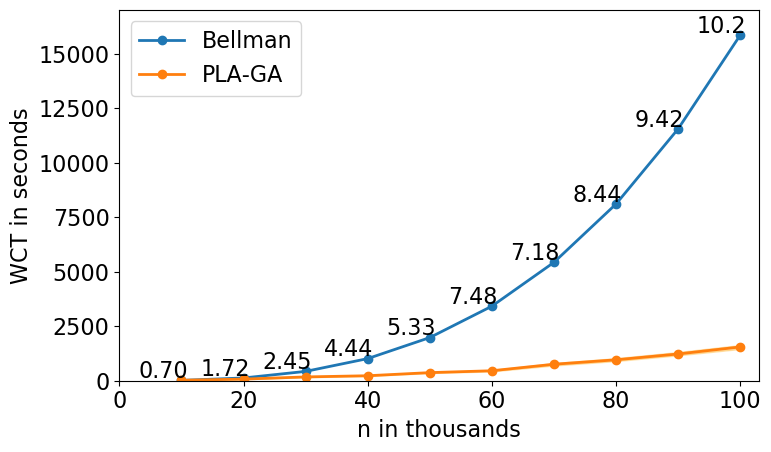

10.0 22.512025797699998
20.0 74.9581152861
30.0 175.47427253214
40.0 235.73328074244003
50.0 376.86848965352
60.0 468.2397896067199
70.0 754.53195539334
80.0 980.4791502916199
90.0 1228.7379174877997
100.0 1586.4038455720602


In [17]:
ds = "subject103_6"
plotTimeUntilBellman(ds)
xlim(0,103)
ylim(0,17000)
tight_layout()
savefig("Scaling Quantile $ds.png", bbox_inches="tight")

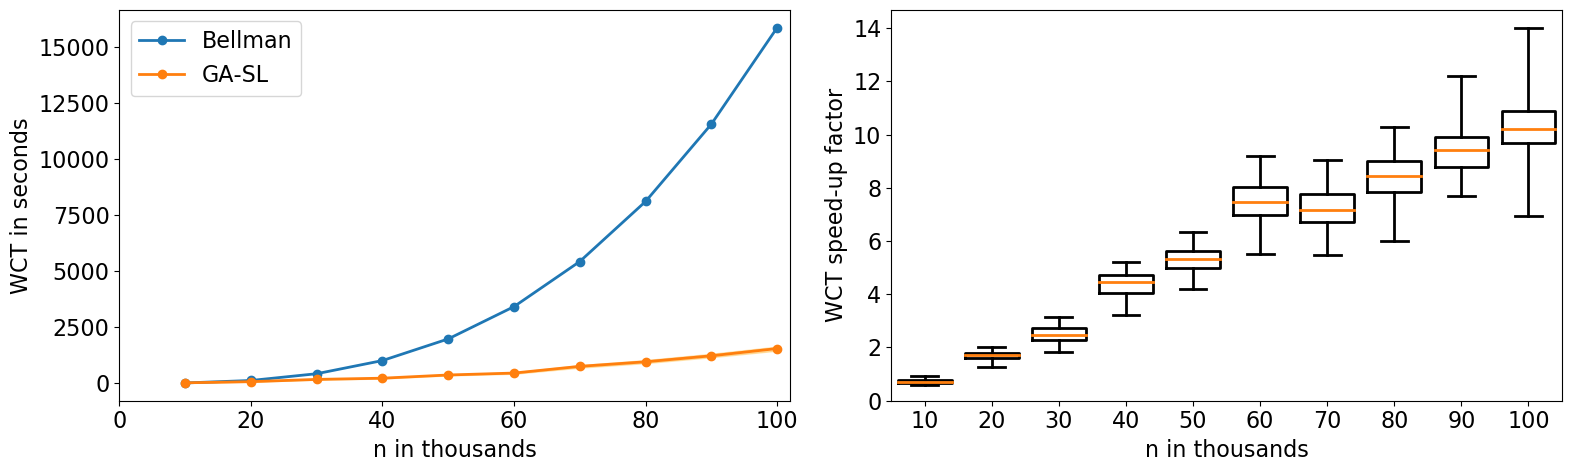

10.0 22.512025797699998
20.0 74.9581152861
30.0 175.47427253214
40.0 235.73328074244003
50.0 376.86848965352
60.0 468.2397896067199
70.0 754.53195539334
80.0 980.4791502916199
90.0 1228.7379174877997
100.0 1586.4038455720602


In [25]:
ds = "subject103_6"
ax1, ax2 = boxplotTimeUntilBellman(ds)
plt.subplot(ax1)
xlim(0,102)
#ylim(0,16000)
plt.subplot(ax2)
#yscale("log")
#ylim(1)
tight_layout()
savefig("Scaling $ds.png", bbox_inches="tight")

In [11]:
bellmanWCT_table()

$10K$ & $

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = bellmanWCT_table() at In[8]:56
└ @ Main .\In[8]:56
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = bellmanWCT_table() at In[8]:57
└ @ Main .\In[8]:57


15.87$ & $0.26$ \\
$20K$ & $126.45$ & $0.11$ \\
$30K$ & $427.96$ & $2.24$ \\
$40K$ & $1014.21$ & $4.83$ \\
$50K$ & $1978.33$ & $2.92$ \\
$60K$ & $3417.04$ & $4.50$ \\
$70K$ & $5426.64$ & $10.47$ \\
$80K$ & $8100.34$ & $10.22$ \\
$90K$ & $11544.10$ & $47.34$ \\
$100K$ & $15840.05$ & $68.63$ \\


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = bellmanWCT_table() at In[8]:59
└ @ Main .\In[8]:59
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = bellmanWCT_table() at In[8]:59
└ @ Main .\In[8]:59


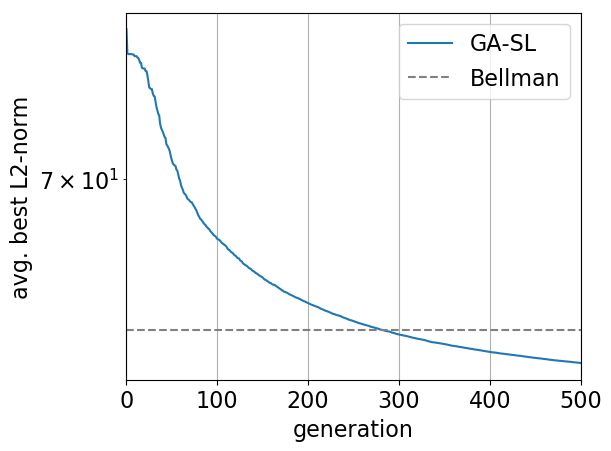

In [3]:
ds = "subject103_5"
plotProblem(ds, 30000, 300)
yscale("log")
title("")
tight_layout()
savefig("fourGAs_$ds", bbox_inches="tight")

algo = ramer_douglas_peucker
dataset_names[i] = "subject103_5"
dataset_names[i] = "subject103_6"
dataset_names[i] = "Ham"
dataset_names[i] = "Rock"
algo = visvalingam_squarederror
dataset_names[i] = "subject103_5"
dataset_names[i] = "subject103_6"
dataset_names[i] = "Ham"
dataset_names[i] = "Rock"
algo = swing_filter_number
dataset_names[i] = "subject103_5"
dataset_names[i] = "subject103_6"
dataset_names[i] = "Ham"

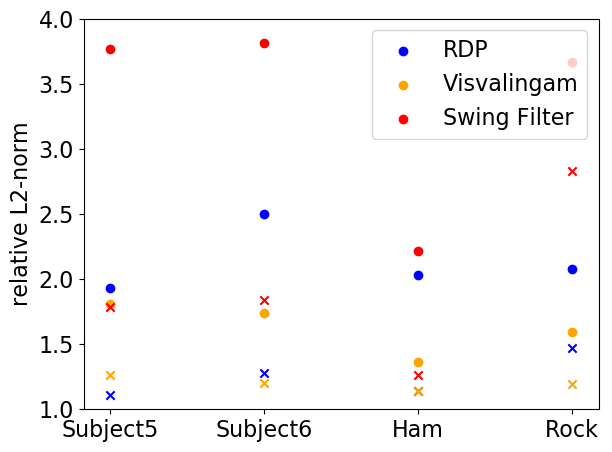


dataset_names[i] = "Rock"


In [53]:
plotL2ofEstablished(10000, 100)
tight_layout()
savefig("literature_algos_comparison.png", bbox_inches="tight")

In [5]:
ts = datasetbyname("Rock")
pygui(true)
plotTs(ts, label="time series")
ylabel("value")
xlabel("time")
xlim((62300, 63000))
ylim((-530, -524))
legend()
tight_layout()
#savefig("timeseries_example.png", bbox_inches="tight")

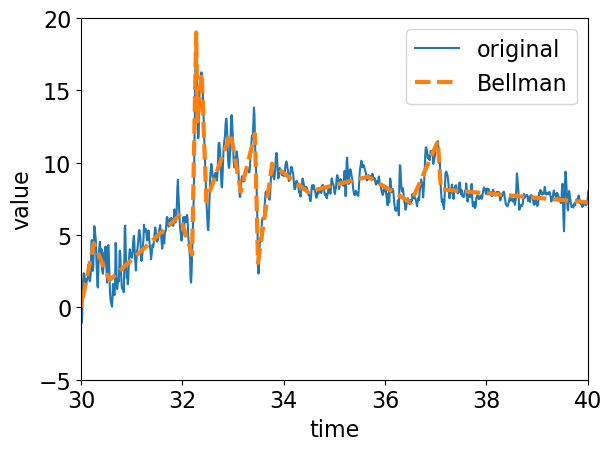

In [38]:
include("src/bellman.jl")
name = "subject103_6"#MixedShapesRegularTrain#UWaveGestureLibraryAll#"Ham"
ts = datasetbyname(name)[1:10000]
compressed, geno = bellman_notable(ts, 100)
plotTs(ts, label="original")
plotTs(compressed, label="Bellman", linestyle="--", linewidth=3)
ylabel("value")
xlabel("time")
xlim((30,40))
ylim(-5,20)
length(ts)
legend()
#grid()
tight_layout()
savefig("dataset_$(name)_extract.png", bbox_inches="tight")

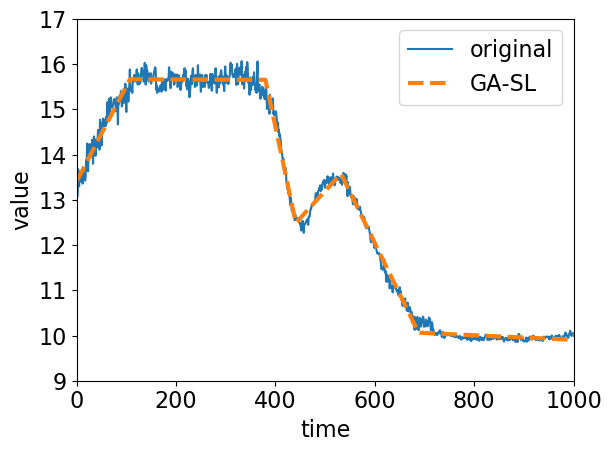

In [43]:
name = "Rock"
ts = datasetbyname(name)[1:10000]
compressed = firstIndividualBeatingBellman(name, 10000, 100).pheno
plotTs(ts, label="original")
plotTs(compressed, label="GA-SL", linestyle="--", linewidth=3)
ylabel("value")
xlabel("time")
xlim(0,1000)
ylim(9,17)
length(ts)
legend()
#grid()
tight_layout()
savefig("GA_result_$(name)_extract.png", bbox_inches="tight")

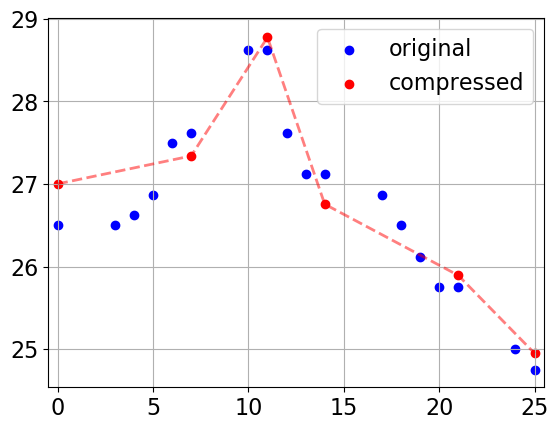

In [19]:
ts = datasetbyname("apple")[1:18]
compressed, geno = swing_filter_number(ts, 6)
rightBoundC = 6
compressed[1] = (compressed[1][1], compressed[1][2]+0.5)
compressed[rightBoundC] = (compressed[rightBoundC][1], compressed[rightBoundC][2]+0.2)
scatterTs(ts, color="blue", alpha=1, label="original")
#plotTs(ts, color="blue", alpha=0.5, linestyle="--")
scatterTs(compressed[1:rightBoundC], color="red", alpha=1, label="compressed")
plotTs(compressed[1:rightBoundC], color="red", alpha=0.5, linestyle="--", linewidth=2)
grid()
xlim((timeof(compressed[1])-0.5, timeof(compressed[rightBoundC])+0.5))
legend()
#ylim((-2, 1))
savefig("compression_example.png", bbox_inches="tight")

In [42]:
using Plots
rng = -5:0.01:5
f(x,y) = 0.5*abs(x*y) - x + 0.5y
p = Plots.plot(rng, rng, f, st = [:surface], grid="true", zlim=(-5, 20), xlabel="x", ylabel="y")
for i in -5:5
    fixed_x = [i for j in 1:length(rng)]
    z = map(f, fixed_x, rng)
    plot!(p[1], fixed_x, rng, z, line = (:white, 2, 0.5), label="")
end
for i in -5:5
    fixed_y = [i for j in 1:length(rng)]
    z = map(f, rng, fixed_y)
    plot!(p[1], rng, fixed_y, z, line = (:white, 2, 0.5), label="")
end
plot!(p[1], camera=(60,60))
png("fitness_landscape_example", bbox_inches="tight")

┌ Warning: Skipped grid arg true.
└ @ Plots C:\Users\ArthurZ\.julia\packages\Plots\oiirH\src\args.jl:811
┌ Warning: Skipped grid arg true.
└ @ Plots C:\Users\ArthurZ\.julia\packages\Plots\oiirH\src\args.jl:811
┌ Warning: Skipped grid arg true.
└ @ Plots C:\Users\ArthurZ\.julia\packages\Plots\oiirH\src\args.jl:811
GKS: invalid bitmap size


### Special Objective for Visvalingam

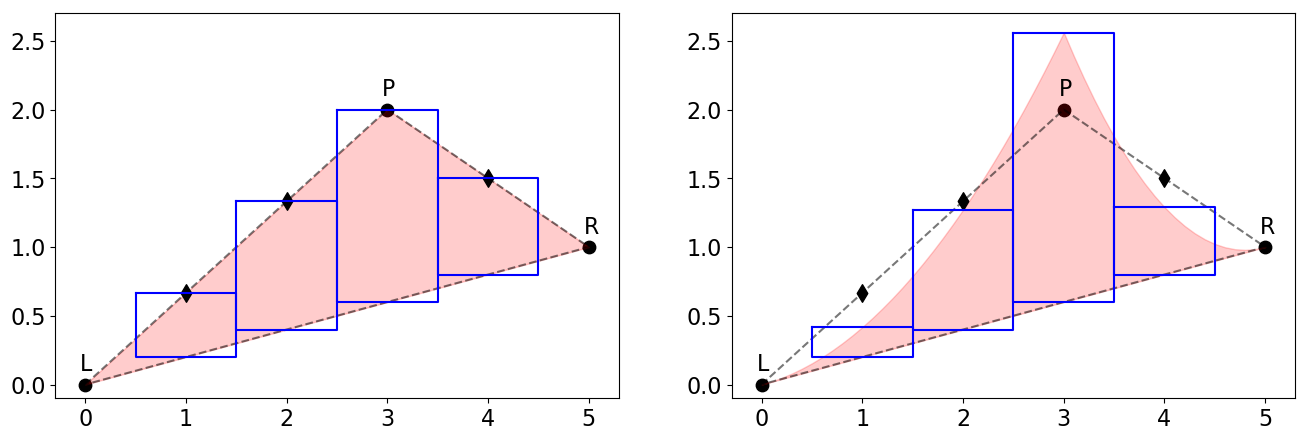

In [8]:
left = (0, 0)
mid = (3, 2)
right = (5, 1)
function base_at(x)
    return left[2] + (x - left[1]) * ((right[2] - left[2]) / (right[1] - left[1]))
end
function top_at(x)
    if x <= mid[1]
        return left[2] + (x - left[1]) * ((mid[2] - left[2]) / (mid[1] - left[1]))
    else
        return mid[2] + (x - mid[1]) * ((right[2] - mid[2]) / (right[1] - mid[1]))
    end
end
function squaredtop_at(x)
    b = base_at(x)
    t = top_at(x)
    return b + (t-b)^2
end

function plotMeasure(top_func)
    PyPlot.plot([left[1], mid[1], right[1], left[1]], [left[2], mid[2], right[2], left[2]], c="#00000088", linestyle="dashed")
    PyPlot.scatter([left[1], mid[1], right[1]], [left[2], mid[2], right[2]], s=80, c="black")
    times = 0:0.1:5
    fill_between(times, top_func.(times), base_at.(times), alpha=0.2, color="red")
    PyPlot.scatter([1,2,4], top_at.([1,2,4]), marker="d", s=80, color="black")
    for x in 1:4
        plot([x-0.5, x+0.5, x+0.5, x-0.5, x-0.5], [top_func(x), top_func(x), base_at(x), base_at(x), top_func(x)], color="blue") 
    end
    text(left[1]-0.05, left[2]+0.1, "L")
    text(mid[1]-0.05, mid[2]+0.1, "P")
    text(right[1]-0.05, right[2]+0.1, "R")
end
    
fig = figure("Visvalingam Error Measures", figsize=(2*8,5));
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
plt.subplot(ax1)
ylim(-0.1, 2.7)
plotMeasure(top_at)
plt.subplot(ax2)
ylim(-0.1,2.7)
plotMeasure(squaredtop_at)

PyPlot.savefig("visvalingam_error_measure.png", bbox_inches="tight")

### Ramer Douglas Peucker

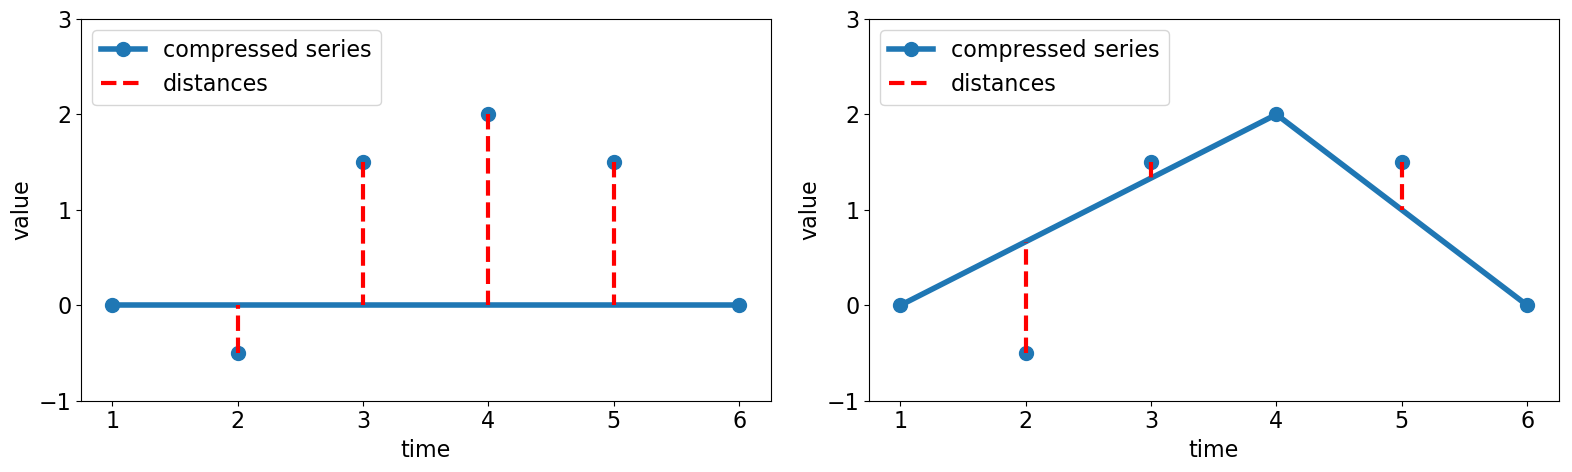

In [87]:
ts = [(1.0,0.0), (2.0, -0.5), (3.0, 1.5), (4.0, 2.0), (5.0, 1.5), (6.0, 0.0)]
fig = figure("", figsize=(2*8,5));
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plt.subplot(ax1)
plot([ts[1][1], ts[6][1]], [ts[1][2], ts[6][2]], marker="o", markersize=10,  linewidth=4, label="compressed series")
for i in [2, 3, 4, 5]
    plot([ts[i][1], ts[i][1]], [ts[i][2], 0], linestyle="--", color="red", linewidth=3, label = (i==2 ? "distances" : ""))
end
scatter([ts[2][1], ts[3][1], ts[4][1], ts[5][1]], [ts[2][2], ts[3][2], ts[4][2], ts[5][2]], s=100)
ylim((-1, 3))
ylabel("value")
xlabel("time")
legend(loc="upper left")
yticks([-1,0,1,2,3])

plt.subplot(ax2)
plot([ts[1][1], ts[4][1], ts[6][1]], [ts[1][2], ts[4][2], ts[6][2]], marker="o", markersize=10,  linewidth=4, label="compressed series")
for i in [2, 3, 5]
    plot([ts[i][1], ts[i][1]], [ts[i][2], i < 4 ? (i-1)*2/3 : 1], linestyle="--", color="red", linewidth=3, label = (i==2 ? "distances" : ""))
end
scatter([ts[2][1], ts[3][1], ts[5][1]], [ts[2][2], ts[3][2], ts[5][2]], s=100)
ylim((-1, 3))
ylabel("value")
xlabel("time")
legend(loc="upper left")
yticks([-1,0,1,2,3])

tight_layout()

savefig("ramer_douglas_peucker_example.png", bbox_inches="tight")

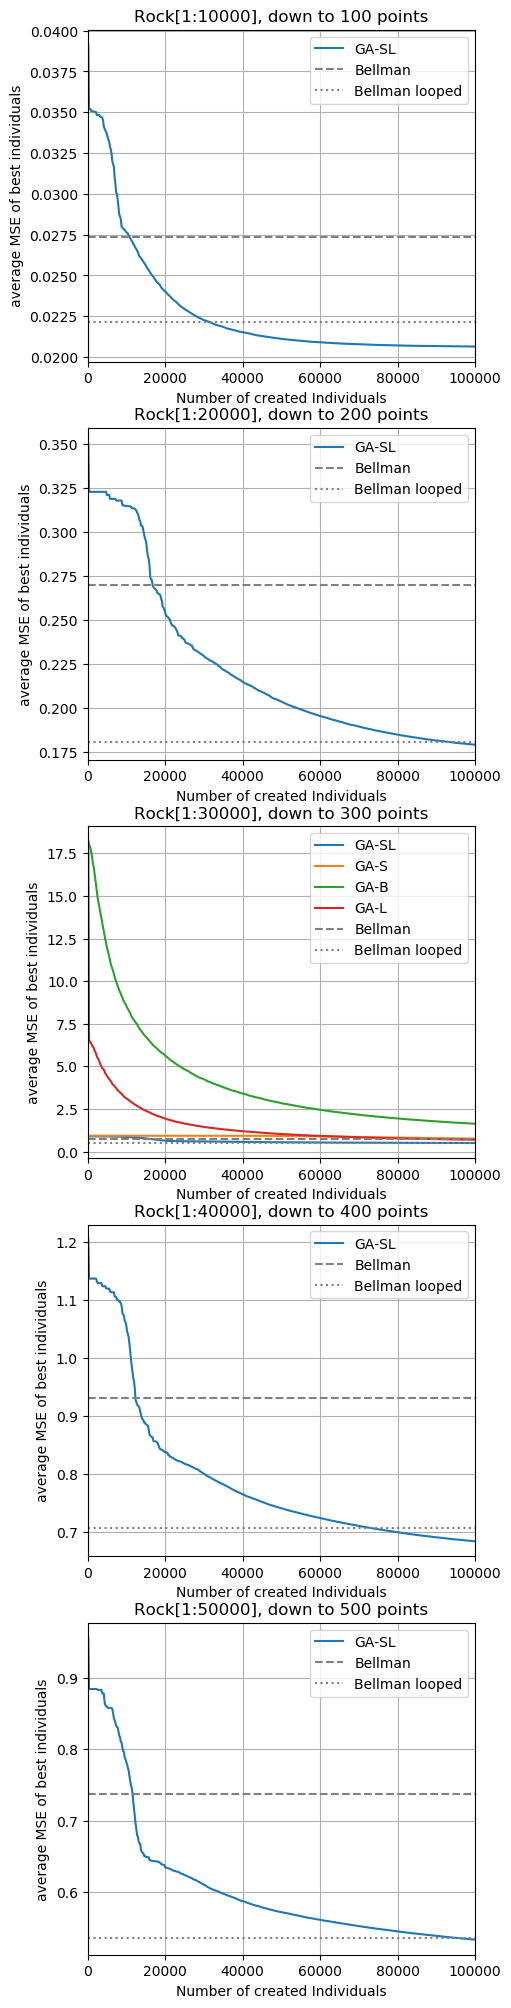

(Figure(PyObject <Figure size 500x2500 with 5 Axes>), Any[PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000039D8EE10>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x000000002DF39C88>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000039D79CF8>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x000000003D388400>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x000000003D3C2E80>])

In [54]:
#MixedShapesRegularTrain#UWaveGestureLibraryAll#Ham#Rock#subject103_6
plotScalingCompression("Rock")
#savefig("example_ga_plot", bbox_inches="tight")

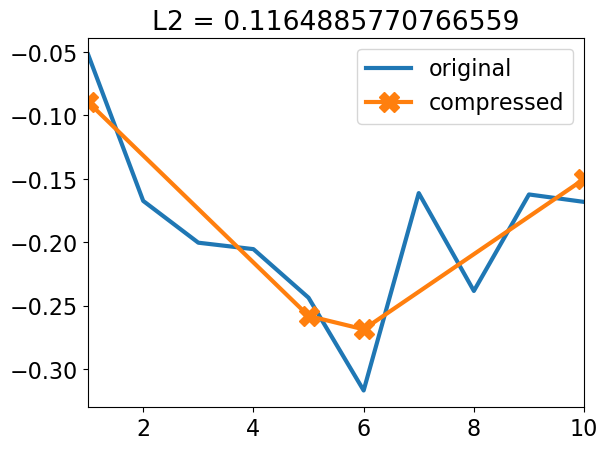

In [65]:
ts = datasetbyname("subject103_5")[5:14]
ts = Timeseries(collect(enumerate(valuesof(ts))))
xlim(1,10)
plotTs(ts, linewidth=3, label="original")
geno = falses(8)
geno[3] = geno[7] = true
ind = Individual(geno, ts)
looped, newGeno = loop(ind.pheno, ts)
ind = Individual(newGeno, ts)
plotTs(ind.pheno, marker="X", linewidth=3, markersize=15, label="compressed")
legend()
l2 = sqrt(mse(ind.pheno, ts)*10)
title("L2 = $l2")
savefig("GA compression_looped.png")